### T-Period Consumption-Saving Model with Labor Supply

Solves a $T$-period consumption-saving model with endogenous labor supply and no uncertainty.

At each period $ t = 1, \dots, T $, the agent chooses consumption  $c_t$ and labor supply $\ell_t \in [0, 1] $ to maximize lifetime utility, trading off consumption gains with labor disutility:

$$
\begin{align}
V_t(a_t) &= \max_{c_t > 0, \; \ell_t \in [0,1]} \left\{ \frac{c_t^{1-\rho}}{1-\rho} - \varphi \cdot \frac{\ell_t^{1+\eta}}{1+\eta} + \beta \cdot V_{t+1}(a_{t+1}) \right\} \\
\text{s.t.} \quad a_{t+1} &= (1 + r) \left[a_t + y_t + w_t \cdot \ell_t - c_t \right] \\
a_t &\geq 0 \quad \text{(No borrowing)}
\end{align}
$$


### Model Parameter Settings

| **Parameter**   | **Value**                             | **Description**                             |
|------------------|-----------------------------------------|---------------------------------------------|
| `T`              | 50                                      | Number of periods                           |
| `β` (`beta`)     | 0.98                                    | Discount factor                             |
| `ρ` (`rho`)      | 2.0                                     | Relative risk aversion (CRRA)               |
| `ϕ` (`ϕ`)        | 2.0                                     | Weight on disutility of labor               |
| `η` (`eta`)      | 2.5                                     | Inverse Frisch elasticity                   |
| `w`              | 20,000                                  | Constant wage rate                          |
| `r`              | 0.02                                    | Interest rate                               |
| `a_max`          | 150,000                                 | Maximum assets in the grid                  |
| `Na`             | 100                                     | Number of asset grid points                 |
| `Nk`             | 50                                      | Number of labor supply grid points          |
| `k_grid`         | `nonlinspace(0.0, k_max, Nk, 1.1)`      | Labor supply from 0 (no work) to 1 (full)   |
| `a_grid`         | `nonlinspace(0.0, a_max, Na, 2.0)`      | Nonlinear asset grid (curved toward 0)      |

### Setup

In [ ]:
using Random, Optim, LinearAlgebra, Interpolations
using Plots, Statistics, ProgressMeter, ForwardDiff, Distributions

### Model

In [9]:
# -------------------------------
# Utility: Nonlinear Grid Creator
# -------------------------------
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end



# -------------------------------
# Dynamic Labor Model Definition
# -------------------------------
mutable struct ConSavLabor
    T::Int                        # Time periods
    rho::Float64                 # Risk aversion (CRRA)
    beta::Float64                # Discount factor
    phi::Float64                 # Weight on labor disutility
    eta::Float64                 # Frisch elasticity parameter
    alpha::Float64               # (possibly productivity or returns to labor)
    w::Float64                   # Wage rate
    y::Float64                   # Non-labor income
    tau::Float64                 # Labor income tax
    r::Float64                   # Interest rate
    a_max::Float64               # Max asset level
    a_min::Float64               # Min asset level
    Na::Int                      # Number of asset grid points
    k_max::Float64               # Max labor effort
    Nk::Int                      # Number of labor grid points
    simT::Int                    # Simulation time periods
    simN::Int                    # Number of simulated agents
    a_grid::Vector{Float64}      # Asset grid
    k_grid::Vector{Float64}      # Labor grid
    sol_c::Array{Float64,3}      # Optimal consumption [T, Nn, Na, Nk]
    sol_h::Array{Float64,3}      # Optimal labor effort [T, Nn, Na, Nk]
    sol_v::Array{Float64,3}      # Value function [T, Nn, Na, Nk]
    sim_c::Array{Float64,2}      # Simulated consumption [simN, simT]
    sim_h::Array{Float64,2}      # Simulated labor [simN, simT]
    sim_a::Array{Float64,2}      # Simulated assets [simN, simT]
    sim_k::Array{Float64,2}      # Simulated labor choice [simN, simT]
    sim_a_init::Vector{Float64}  # Initial assets
    sim_k_init::Vector{Float64}  # Initial labor effort
    draws_uniform::Array{Float64,2}  # Uniform draws for simulation [simN, simT]
    w_vec::Vector{Float64}       # Time-varying wage vector [T]
end

# -------------------------------
# Constructor for ConSavLabor
# -------------------------------
function ConSavLabor(; T::Int=50, beta::Float64=0.98, rho::Float64=2.0, y::Float64=30_000.0,
                           r::Float64=0.02, a_max::Float64=300_000.0, Na::Int=100, simN::Int=5000,
                           a_min::Float64=0.0, k_max::Float64=50.0, Nk::Int=50,
                           w::Float64=20_000.0, tau::Float64=0.1,
                           eta::Float64=2.5, alpha::Float64=0.3,
                           phi::Float64=2.0, seed::Int=1234)

    # --- Time horizon and simulation settings ---
    simT = T

    # --- Grids for state variables and decisions ---
    a_grid = nonlinspace(a_min, a_max, Na, 2.0)
    k_grid = nonlinspace(0.0, k_max, Nk, 1.1)

    # --- Storage for solution (policy + value functions) ---
    # Dimensions: (T, Na, Nk) 
    sol_shape = (T, Na, Nk)
    sol_c = fill(NaN, sol_shape)   # Optimal consumption
    sol_h = fill(NaN, sol_shape)   # Optimal labor effort
    sol_v = fill(NaN, sol_shape)   # Value function

    # --- Simulation storage ---
    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)

    # --- Random draws for simulation ---
    rng = MersenneTwister(seed)
    draws_uniform = rand(rng, sim_shape...)

    # --- Initial conditions for simulation ---
    sim_a_init = zeros(Float64, simN)
    sim_k_init = zeros(Float64, simN)

    # --- Wage vector (can vary by time) ---
    w_vec = fill(w, T)

    # --- Return constructed model ---
    return ConSavLabor(T, rho, beta, phi, eta, alpha, w, y, tau, r,
                          a_max, a_min, Na, k_max, Nk, simT, simN,
                          a_grid, k_grid,
                          sol_c, sol_h, sol_v,
                          sim_c, sim_h, sim_a, sim_k,
                          sim_a_init, sim_k_init, draws_uniform, w_vec)
end





ConSavLabor

In [ ]:
# --------------------------
# Model Solver
# --------------------------

function solve_model!(model::ConSavLabor)
    T, Na, Nk = model.T, model.Na, model.Nk
    a_grid, k_grid = model.a_grid, model.k_grid
    sol_c, sol_h, sol_v = model.sol_c, model.sol_h, model.sol_v

    @showprogress 1 "Solving model..." for t in T:-1:1

        for (i_a, assets) in enumerate(a_grid)
            for (i_k, capital) in enumerate(k_grid)
                idx = (t, i_a, i_k)  # `1` is a dummy index to preserve 4D shape
                w = wage_func(model, capital, t)

                if t == T
                    # =============== LAST PERIOD (UNIVARIATE) ===============
                    f(hours) = obj_last(model, hours, assets, capital)

                    # Restrict h ∈ [0, 1]
                    lower_bound = 0.0
                    upper_bound = 1.0

                    res = optimize(f, lower_bound, upper_bound, GoldenSection())

                    h_opt = Optim.minimizer(res)
                    cons = cons_last(model, h_opt, capital, assets)

                    sol_h[idx...] = h_opt
                    sol_c[idx...] = cons
                    sol_v[idx...] = -Optim.minimum(res)

                else
                    # =============== EARLIER PERIODS (MULTIVARIATE) ===============

                    obj(x) = -value_of_choice(model, x[1], x[2], assets, capital, t)

                    # Initial guess from next period
                    idx_last = (t+1, i_a, i_k)
                    init = [sol_c[idx_last...], sol_h[idx_last...]]

                    # Box constraints: h ∈ [0, 1]
                    lb = [1e-6, 0.0]
                    ub = [Inf,   1.0]

                    res = optimize(obj, lb, ub, init,
                                   Fminbox(LBFGS()),
                                   Optim.Options(g_tol=1e-6))

                    sol_c[idx...] = Optim.minimizer(res)[1]
                    sol_h[idx...] = Optim.minimizer(res)[2]
                    sol_v[idx...] = -Optim.minimum(res)
                end
            end
        end
    end

    return model
end


# ------------------------------------------------
# Supporting functions 
# ------------------------------------------------

@inline function cons_last(model::ConSavLabor, h::Float64, capital::Float64, assets::Float64)
    # Compute income from wages at the terminal period
    income = wage_func(model, capital, model.T) * h 
    # Terminal consumption: all available resources are consumed
    cons = assets + income
    return cons
end

@inline function obj_last(model::ConSavLabor, h::Float64, assets::Float64, capital::Float64)
    # Compute consumption in the last period given hours worked
    cons = cons_last(model, h, capital, assets)
    # Calculate the utility; note: using the modified util without fertility
    u = util(model, cons, h)
    # Objective for maximization (we minimize the negative utility)
    return -u
end

@inline function util(model::ConSavLabor, c, h)
    # Utility from consumption and disutility from labor.
    # Note: we use par.phi (the weight on labor disutility) in place of a kids-adjusted parameter.
    par = model
    return (c^(1.0 - par.rho)) / (1.0 - par.rho) - par.phi * (h^(1.0 + par.eta)) / (1.0 + par.eta)
end

@inline function wage_func(model::ConSavLabor, capital::Float64, t::Int)
    # Compute the effective wage: after tax wage rate adjusted for capital effects.
    par = model  # Extract model parameters
    return (1.0 - par.tau) * par.w_vec[t] * (1.0 + par.alpha * capital)
end

function value_of_choice(model::ConSavLabor, cons, hours, assets, capital, t::Int)
    par = model
    sol_v = model.sol_v
    a_grid, k_grid = model.a_grid, model.k_grid

    # Apply penalties for constraint violations.
    penalty = 0.0
    penalty += (cons < 0.0)  ? cons * 10000.0 : 0.0
    penalty += (hours < 0.0) ? hours * 10000.0 : 0.0
    #penalty += (assets < 0.0) ? assets * 1000000.0 : 0.0

    # Current period utility.
    util_val = util(model, cons, hours)

    # Next period states:
    income = wage_func(model, capital, t) * hours
    a_next = (1.0 + par.r) * (assets + income - cons)
    k_next = capital + hours

    # Interpolate next period's value using 3D array indexing.
    interp = LinearInterpolation((a_grid, k_grid), sol_v[t+1, :, :], extrapolation_bc=Line())
    V_next = interp(a_next, k_next)

    return util_val + par.beta * V_next + penalty
end

# ------------------------------------------------
# Gradient-based wrappers
# ------------------------------------------------

@inline function neg_value_of_choice(x, model, assets, capital, t)
    # Return the negative total value for minimization.
    return -value_of_choice(model, x[1], x[2], assets, capital, t)
end

@inline function grad_neg_value_of_choice!(storage, x, model, assets, capital, t)
    # Use ForwardDiff to compute the gradient.
    ForwardDiff.gradient!(
        storage,
        y -> neg_value_of_choice(y, model, assets, capital, t),
        x
    )
end

# --------------------------
# Simulation
# --------------------------
# Simulate consumption and asset paths based on the solved policy functions

function simulate_model!(model::ConSavLabor)
    simN, simT = model.simN, model.simT
    sim_a, sim_k = model.sim_a, model.sim_k
    sim_c, sim_h = model.sim_c, model.sim_h
    draws_uniform = model.draws_uniform

    # Precompute interpolation objects for each period.
    # sol_c and sol_h are assumed to be 3D arrays: dimensions (T, Na, Nk)
    interp_dict = Dict()
    for t in 1:simT
        sol_c_slice = model.sol_c[t, :, :]
        sol_h_slice = model.sol_h[t, :, :]
        interp_dict[(t, :c)] = LinearInterpolation((model.a_grid, model.k_grid), sol_c_slice, extrapolation_bc=Line())
        interp_dict[(t, :h)] = LinearInterpolation((model.a_grid, model.k_grid), sol_h_slice, extrapolation_bc=Line())
    end

    # Initialize simulation with initial asset and capital conditions.
    for i in 1:simN
        sim_a[i, 1] = model.sim_a_init[i]
        sim_k[i, 1] = model.sim_k_init[i]
    end

    # Simulation loop.
    for i in 1:simN
        for t in 1:simT
            sim_c[i, t] = interp_dict[(t, :c)](sim_a[i, t], sim_k[i, t])
            sim_h[i, t] = interp_dict[(t, :h)](sim_a[i, t], sim_k[i, t])
            # Ensure hours stay in [0, 1].
            sim_h[i, t] = clamp(sim_h[i, t], 0.0, 1.0)
            if t < simT
                income = wage_func(model, sim_k[i, t], t) * sim_h[i, t]
                sim_a[i, t+1] = (1 + model.r) * (sim_a[i, t] + income - sim_c[i, t])
                sim_k[i, t+1] = sim_k[i, t] + sim_h[i, t]
            end
        end
    end
end


simulate_model! (generic function with 1 method)

### Model and Counterfactual Simulation in a T-Period 
This script solves and simulates a finite-horizon (T-period) consumption-saving model under different economic scenarios. It compares a baseline model with four counterfactual experiments, focusing on how each setting affects average consumption and asset accumulation over time.


In [46]:
# -- Baseline Model (default parameters) --
model_baseline = ConSavLabor()
solve_model!(model_baseline)
simulate_model!(model_baseline)

# -- Counterfactual 1: Tax Rate Variations --
model_low_tax = ConSavLabor(tau = 0.05)
solve_model!(model_low_tax)
simulate_model!(model_low_tax)

model_high_tax = ConSavLabor(tau = 0.20)
solve_model!(model_high_tax)
simulate_model!(model_high_tax)

# -- Counterfactual 2: Wage Variations --

model_high_wage = ConSavLabor(w = 30_000.0)
solve_model!(model_high_wage)
simulate_model!(model_high_wage)

# -- Counterfactual 4: Frisch Elasticity & φ Variations --
# (Baseline: η = 2.5, φ = 2.0)
model_high_fe = ConSavLabor(eta = 1.0 ,phi = 1.0)   # Higher elasticity (η lower) & lower disutility weight
solve_model!(model_high_fe)
simulate_model!(model_high_fe)

model_low_fe = ConSavLabor(eta = 3.5, phi = 3.0)    # Lower elasticity (η higher) & higher disutility weight
solve_model!(model_low_fe)
simulate_model!(model_low_fe)

# -- Counterfactual 5: Initial Assets from Lognormal Distribution --
# ~90% to fall between 5,000 and 20,000
μ = 9.4
σ = 0.45

model_lognormal = ConSavLabor()
model_lognormal.sim_a_init .= rand(LogNormal(μ, σ), model_lognormal.simN)
solve_model!(model_lognormal)
simulate_model!(model_lognormal)




Solving model... 100%|███████████████████████████████████| Time: 0:01:12
Solving model... 100%|███████████████████████████████████| Time: 0:01:08
Solving model... 100%|███████████████████████████████████| Time: 0:01:10
Solving model... 100%|███████████████████████████████████| Time: 0:01:08
Solving model... 100%|███████████████████████████████████| Time: 0:02:59
Solving model... 100%|███████████████████████████████████| Time: 0:01:10
Solving model... 100%|███████████████████████████████████| Time: 0:01:05


###  Model Structure and Policy Function Visualization

This figure displays key components of the solved consumption-saving model:

- **Top-left**: The nonlinear asset grid used in the model, illustrating higher density near low asset levels.
- **Top-right**: Optimal consumption policy at the final period (\( T = 50 \)), where agents consume all available resources.
- **Bottom-left**: The value function at \( T = 50 \), showing expected lifetime utility as a function of asset holdings.
- **Bottom-right**: The optimal consumption policy earlier in life (\( T = 10 \)), when agents still save for future periods.

This layout helps understand how asset grid design and time dynamics influence optimal behavior.

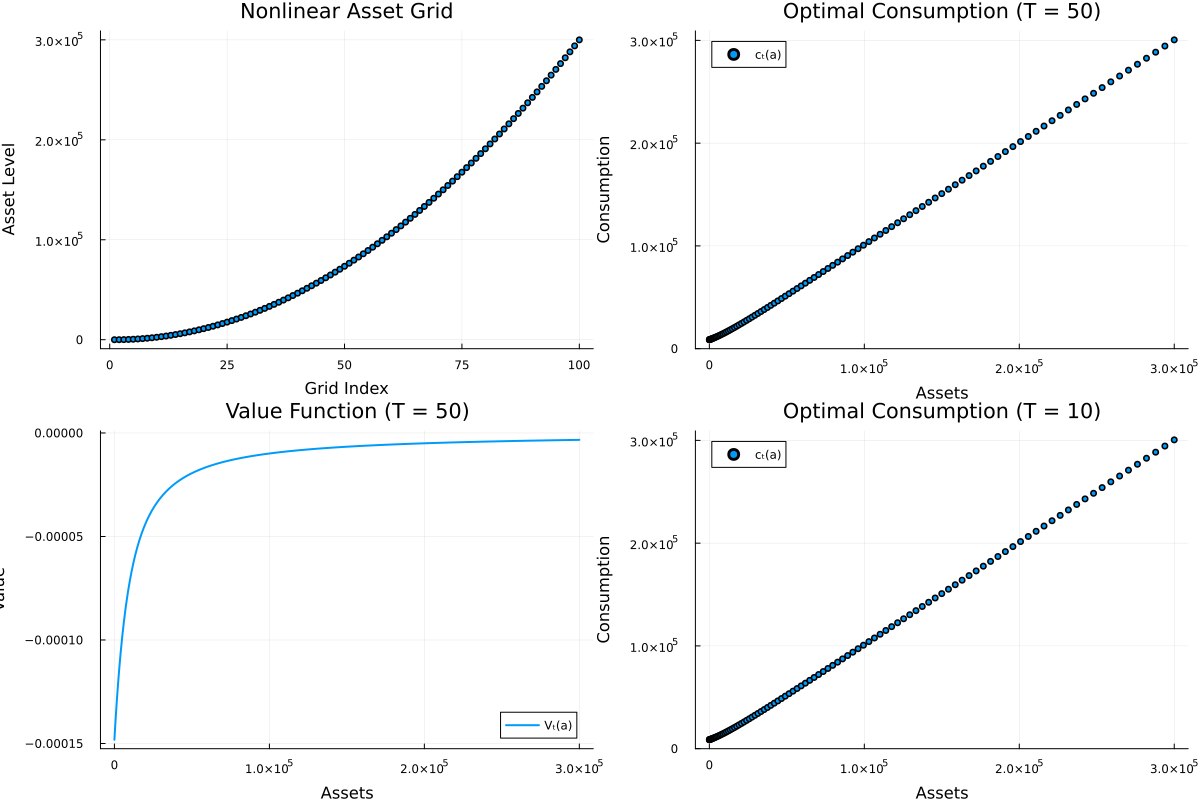

In [47]:

# Choose a representative labor grid index (e.g. the median)
k_mid = Int(ceil(length(model_baseline.k_grid)/2))
T_terminal = model_baseline.T  # Terminal period (e.g., 50)
t_early = 10          # An earlier period for comparison

# 1. Plot the nonlinear asset grid
p1 = scatter(1:length(model_baseline.a_grid), model_baseline.a_grid,
    xlabel = "Grid Index",
    ylabel = "Asset Level",
    title = "Nonlinear Asset Grid",
    legend = false,
    markersize = 3)

# 2. Plot optimal consumption policy at terminal period (T = model.T)
# Here we fix the labor dimension at k_mid.
p2 = scatter(model_baseline.a_grid, model_baseline.sol_c[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(T_terminal))",
    label = "cₜ(a)",
    markersize = 3)

# 3. Plot value function at terminal period (T = model.T)
# Note: use 'sol_v' (not sol_V) as per your definition.
p3 = plot(model_baseline.a_grid, model_baseline.sol_v[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)",
    linewidth = 2)

# 4. Plot optimal consumption policy at an earlier period (e.g., T = 10)
p4 = scatter(model_baseline.a_grid, model_baseline.sol_c[t_early, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(t_early))",
    label = "cₜ(a)",
    markersize = 3)

# Combine all plots into a 2×2 grid layout for comparison
plot(p1, p2, p3, p4, layout = (2, 2), size = (1200, 800))

###  Counterfactual Analysis
We investigate the effects of key economic parameters on individual consumption, savings, labor effort, and human capital accumulation. Our **baseline model** is defined as follows:


In [48]:
t = 1:model_baseline.simT

# Helper function to compute average path over agents
function avg_sim(var)
    return vec(mean(var, dims=1))
end

# Extract averages for all simulated variables
function extract_all(model)
    return (
        c = avg_sim(model.sim_c),
        a = avg_sim(model.sim_a),
        h = avg_sim(model.sim_h),
        k = avg_sim(model.sim_k)
    )
end

# Baseline averages
base = extract_all(model_baseline);


##### Counterfactual 1: **Tax Rate Variations**

We vary the labor income tax rate to examine its impact on work incentives and savings behavior.

- **Baseline:** τ = 0.10  
- **Low Tax:** τ = 0.05  
- **High Tax:** τ = 0.20 

> 💡 **Interpretation:**  
> Lower taxes increase disposable income, which leads to higher consumption and more asset accumulation. Higher taxes reduce both, while increasing labor disincentives.


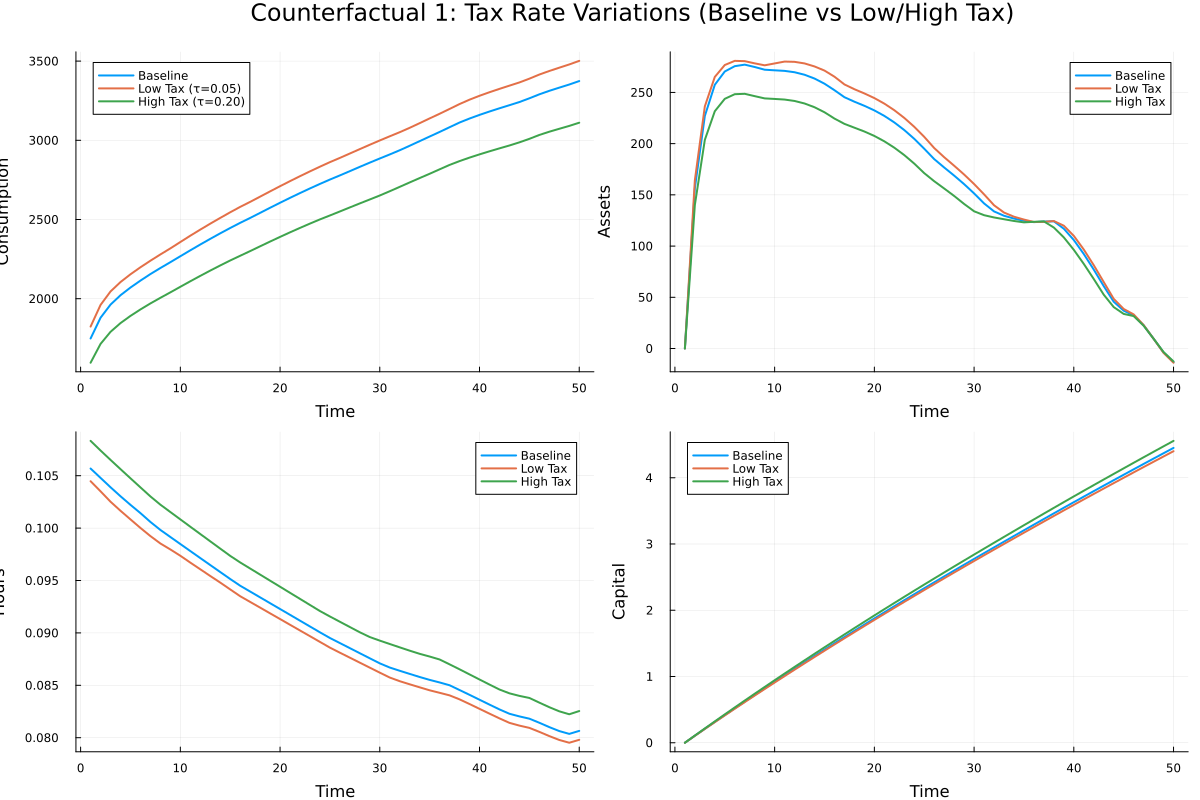

In [49]:
# ----------------------------------------------
# 1. Tax Rate Variations (Low and High Tax)
# ----------------------------------------------
# Remove title from each subplot:
p1 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, low_tax.c, label="Low Tax (τ=0.05)", lw=2)
plot!(t, high_tax.c, label="High Tax (τ=0.20)", lw=2)

p2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets")
plot!(t, low_tax.a, label="Low Tax", lw=2)
plot!(t, high_tax.a, label="High Tax", lw=2)

p3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, low_tax.h, label="Low Tax", lw=2)
plot!(t, high_tax.h, label="High Tax", lw=2)

p4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Capital")
plot!(t, low_tax.k, label="Low Tax", lw=2)
plot!(t, high_tax.k, label="High Tax", lw=2)

# Combine and add ONE title
plot(p1, p2, p3, p4,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 1: Tax Rate Variations (Baseline vs Low/High Tax)",
     titlefont = 16)

##### Counterfactual 2: **Wage Variations**

We increase the wage rate to study the response in labor effort, income, and savings.

- **Baseline:** w = 20,000  
- **High Wage:** w = 30,000  

> 💡 **Interpretation:**  
> A higher wage raises labor income and thus consumption and wealth, with little change in hours worked due to offsetting income and substitution effects.


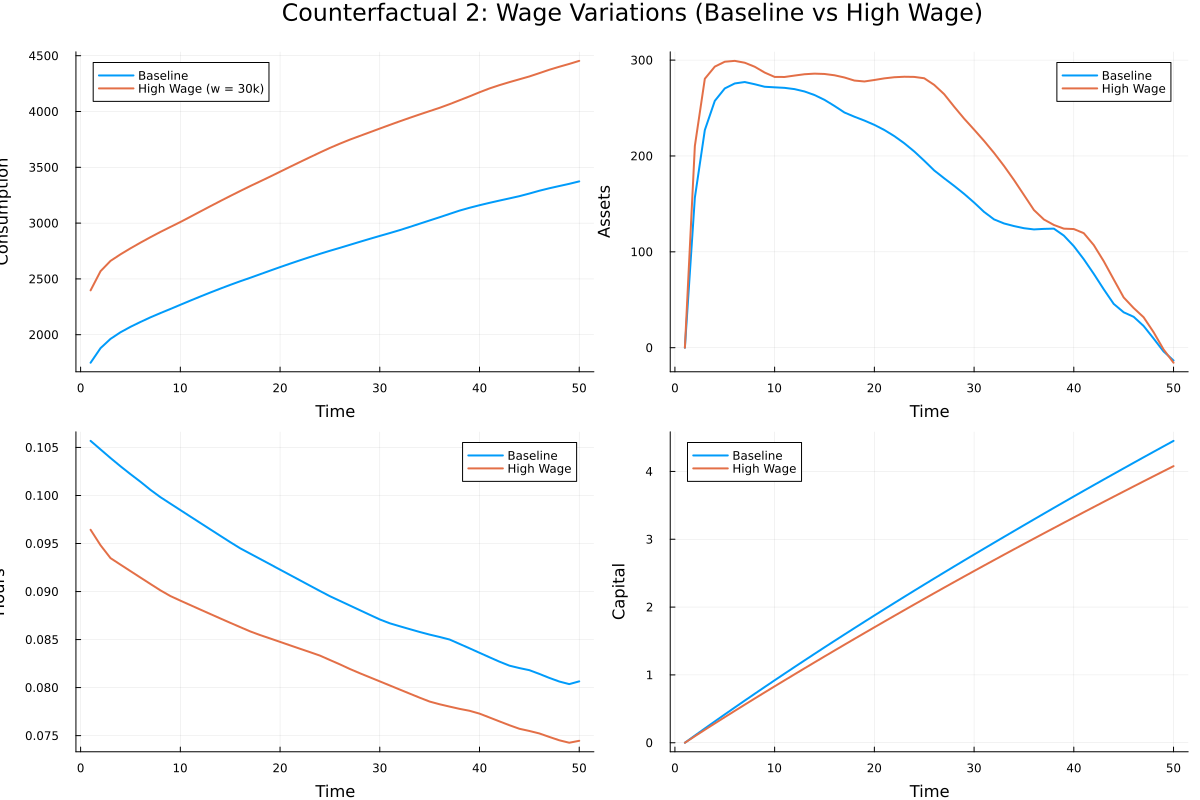

In [50]:
# ----------------------------------------------
# 2. Wage Variations (Baseline vs High Wage)
# ----------------------------------------------
high_wage = extract_all(model_high_wage)

p5 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, high_wage.c, label="High Wage (w = 30k)", lw=2)

p6 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets")
plot!(t, high_wage.a, label="High Wage", lw=2)

p7 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, high_wage.h, label="High Wage", lw=2)

p8 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Capital")
plot!(t, high_wage.k, label="High Wage", lw=2)

plot(p5, p6, p7, p8,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 2: Wage Variations (Baseline vs High Wage)",
     titlefont = 16)

##### Counterfactual 3: **Frisch Elasticity & Labor Disutility**

We vary the elasticity of labor supply (η) and the disutility weight of working (φ).

- **Baseline:** η = 2.5, φ = 2.0  
- **High Frisch Elasticity:** η = 1.0, φ = 1.0  
- **Low Frisch Elasticity:** η = 3.5, φ = 3.0  

> 💡 **Interpretation:**  
> A lower η implies a more elastic labor supply—agents respond more to wage changes. A higher φ increases aversion to working, reducing labor effort overall.


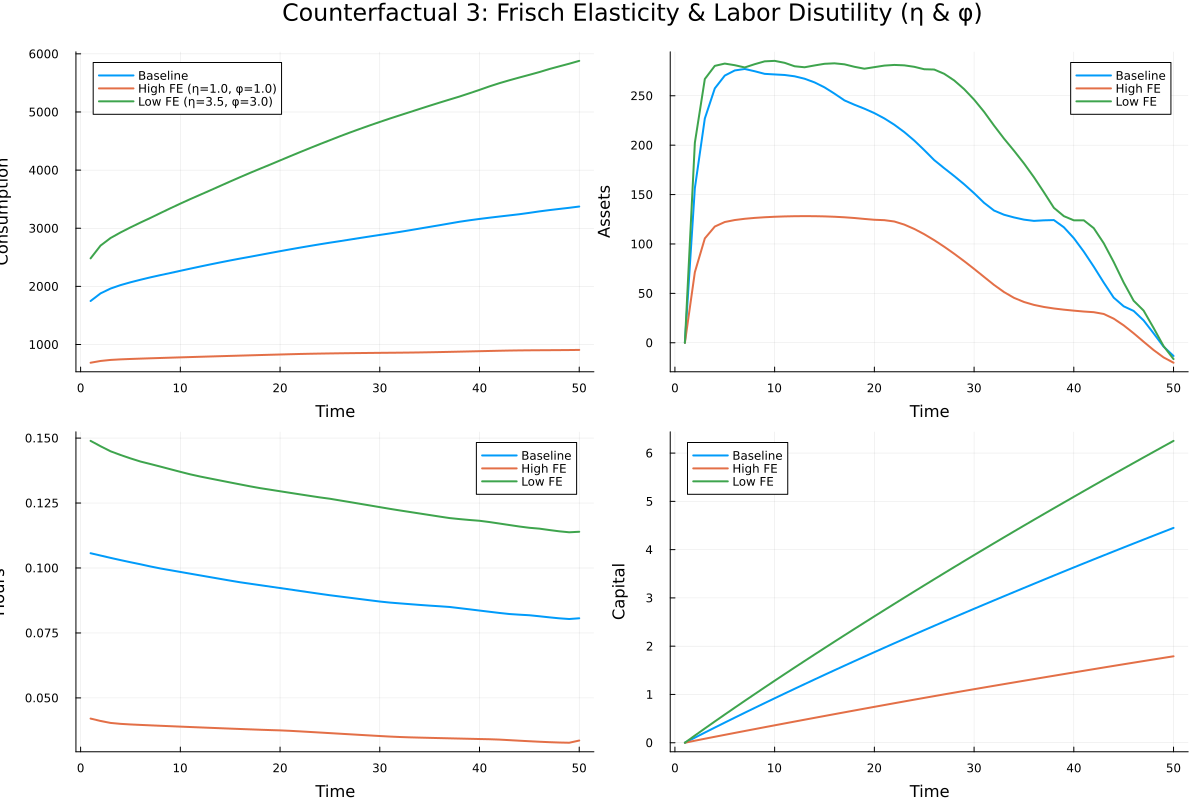

In [51]:
# ----------------------------------------------
# 3. Frisch Elasticity & φ Variations
# ----------------------------------------------
high_fe = extract_all(model_high_fe)
low_fe = extract_all(model_low_fe)

p9 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, high_fe.c, label="High FE (η=1.0, φ=1.0)", lw=2)
plot!(t, low_fe.c, label="Low FE (η=3.5, φ=3.0)", lw=2)

p10 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets")
plot!(t, high_fe.a, label="High FE", lw=2)
plot!(t, low_fe.a, label="Low FE", lw=2)

p11 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, high_fe.h, label="High FE", lw=2)
plot!(t, low_fe.h, label="Low FE", lw=2)

p12 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Capital")
plot!(t, high_fe.k, label="High FE", lw=2)
plot!(t, low_fe.k, label="Low FE", lw=2)

plot(p9, p10, p11, p12,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 3: Frisch Elasticity & Labor Disutility (η & φ)",
     titlefont = 16)

##### Counterfactual 4: **Initial Asset Distribution**

We introduce heterogeneity in initial wealth by drawing from a lognormal distribution.

- **Baseline:** Initial assets = 0  
- **Counterfactual:** Initial assets ∼ LogNormal(μ = 9.4, σ = 0.45; ~90% to fall between 5,000 and 20,000)

> 💡 **Interpretation:**  
> Agents starting with more wealth consume more and work slightly less early in life. Their asset accumulation path is flatter compared to the baseline.

---


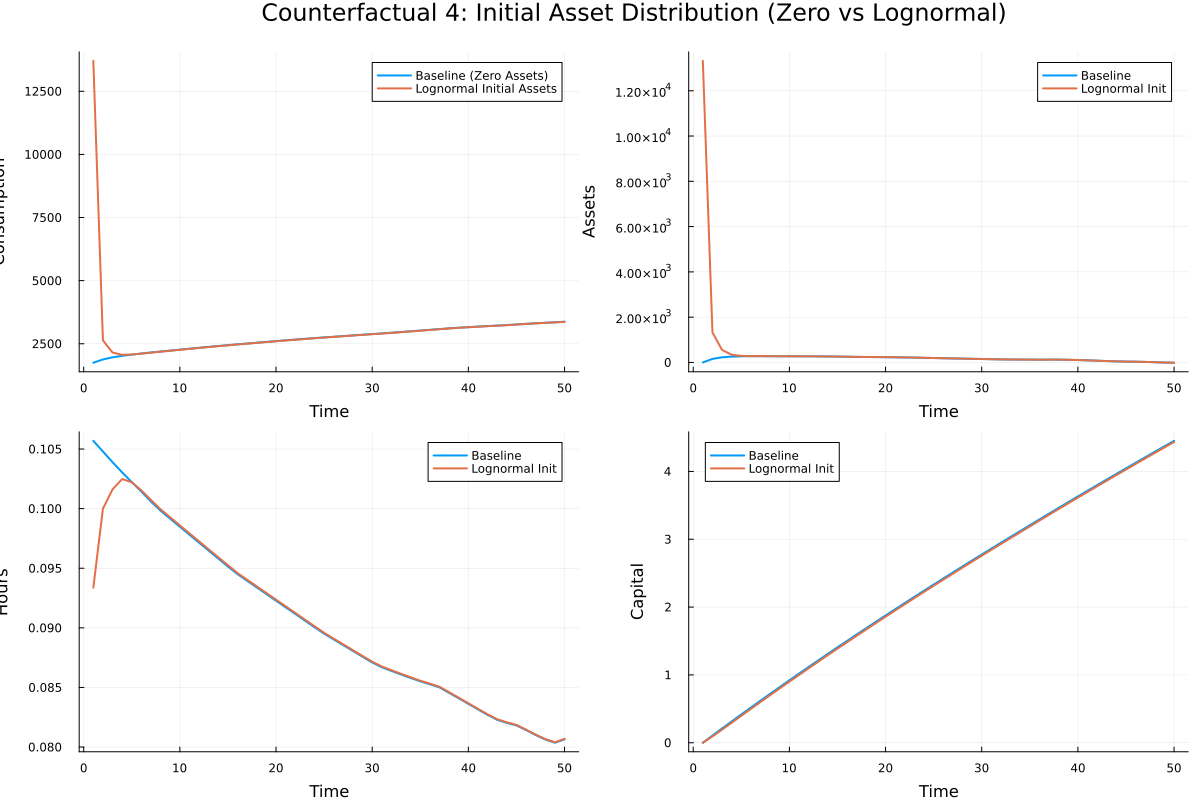

In [52]:
# ----------------------------------------------
# 4. Initial Assets (Baseline vs Lognormal)
# ----------------------------------------------
lognorm = extract_all(model_lognormal)

p13 = plot(t, base.c, label="Baseline (Zero Assets)", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, lognorm.c, label="Lognormal Initial Assets", lw=2)

p14 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets")
plot!(t, lognorm.a, label="Lognormal Init", lw=2)

p15 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, lognorm.h, label="Lognormal Init", lw=2)

p16 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Capital")
plot!(t, lognorm.k, label="Lognormal Init", lw=2)

plot(p13, p14, p15, p16,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 4: Initial Asset Distribution (Zero vs Lognormal)",
     titlefont = 16)